In [1]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import json
import seaborn.apionly as sns
import matplotlib.pyplot as plt

/usr/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/usr/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/lib/python3.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


##1. Take a look at the training data. There may be anomalies in the data that you may need to factor in before you start on the other tasks. Make a note of the anomalies that you notice. Clean the data first to handle these issues. Explain what you did to clean the data (in bulleted form). (10 points)

In [2]:
trainData = pd.read_csv('train.csv', converters={column: json.loads for column in ["device", "geoNetwork", "totals", "trafficSource"]},dtype={'fullVisitorId': 'str', 'date': 'str', 'visitId': 'str'})
trainData.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",1131660440785968503,"{'continent': 'Asia', 'subContinent': 'Western...",1131660440785968503_1472830385,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472830385,1,1472830385
1,Organic Search,20160902,"{'browser': 'Firefox', 'browserVersion': 'not ...",377306020877927890,"{'continent': 'Oceania', 'subContinent': 'Aust...",377306020877927890_1472880147,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472880147,1,1472880147
2,Organic Search,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",3895546263509774583,"{'continent': 'Europe', 'subContinent': 'South...",3895546263509774583_1472865386,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472865386,1,1472865386
3,Organic Search,20160902,"{'browser': 'UC Browser', 'browserVersion': 'n...",4763447161404445595,"{'continent': 'Asia', 'subContinent': 'Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472881213,1,1472881213
4,Organic Search,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",27294437909732085,"{'continent': 'Europe', 'subContinent': 'North...",27294437909732085_1472822600,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472822600,2,1472822600


In [3]:
def norm_json(df):
  columns = ["device", "geoNetwork", "totals", "trafficSource"]

  for col in columns:
    trainDataNormalizedColumn = json_normalize(df[col])
    trainDataNormalizedColumn.columns = [ '{}.{}'.format(col, subcol) for subcol in trainDataNormalizedColumn.columns ]
    df.drop(col, axis=1, inplace=True)
    df = df.merge(trainDataNormalizedColumn, right_index=True, left_index=True)
  return df

In [4]:
def drop_nunique_cols(df):
  df = df.loc[:,df.nunique(dropna=False) != 1]
  df.fillna(0, inplace = True)
  return df

In [5]:
# trainData['totals.transactionRevenue'] = trainData['totals.transactionRevenue'].astype('float')
def convert_type(df):
  dtypeMap = {
      "totals.transactionRevenue": 'float64',
      "totals.bounces": 'int64',
      "totals.newVisits": 'int64',
      "trafficSource.adwordsClickInfo.isVideoAd": 'int64',
      "trafficSource.isTrueDirect": 'int64',
      "totals.hits": 'int64',
      "totals.pageviews": 'int64',
      "date": "str"
  }

  for col in df.columns:
    if col in dtypeMap:
      conv = dtypeMap[col]

      df[col] = df[col].astype(conv)
      
  return df
    

In [6]:
def clean_data(df):
  df1 = norm_json(df)
  df2 = drop_nunique_cols(df1)
  df3 = convert_type(df2)
  return df3

In [7]:
trainData = clean_data(trainData)
trainData.drop(['trafficSource.campaignCode'], inplace=True, axis=1)
# trainData.head()

/usr/lib/python3.7/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2. Generate a heatmap and two other plots (with a subset of variables) visualizing interesting positive and negative correlations. Explain the reason for your choice for these variables and any interesting results associated with them.

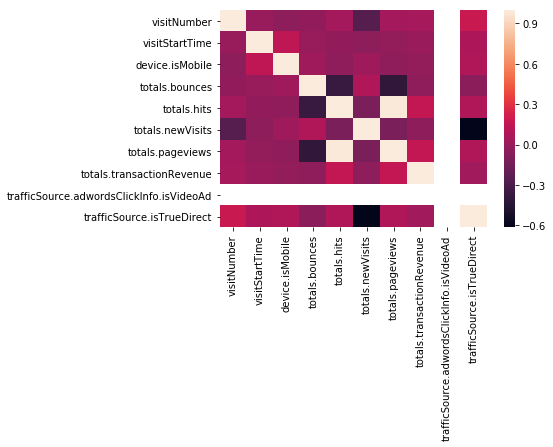

In [8]:
corr = trainData.corr()

sns.heatmap(corr)

In [9]:
def add_date_feature(df):
  df["date"] = df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
  df['date'] =  pd.to_datetime(df['date'])
  df['visitStartTime'] = pd.to_datetime(df['visitStartTime'], unit='s')
  df['year'] = df['visitStartTime'].apply(lambda x: x.year)
  df['month'] = df['visitStartTime'].apply(lambda x: x.month)
  df['day'] = df['visitStartTime'].apply(lambda x: x.day)
  df['hour'] = df['visitStartTime'].apply(lambda x: x.hour)
  df['minute'] = df['visitStartTime'].apply(lambda x: x.minute)
  df['weekday'] = df['visitStartTime'].apply(lambda x: x.weekday())
  
  '''
  We will group the months into season such that:
  Winter -> January, February, December -> 1
  Spring -> March, April, May -> 2
  Summer -> June, July, August -> 3
  Fall -> September, October, November -> 4
  '''
  df['season'] = df['visitStartTime'].apply(lambda x: (x.month%12 + 3)//3)
  df['time_of_day'] = df['visitStartTime'].apply(lambda x: (x.hour%24 + 4)//4)
  return df
   

In [10]:
def add_unique_user_count(df):
  df['user_daily_count'] = df.groupby('day')['fullVisitorId'].transform('nunique')
  df['user_monthly_count'] = df.groupby('month')['fullVisitorId'].transform('nunique')
  df['user_weekday_count'] = df.groupby('weekday')['fullVisitorId'].transform('nunique')
  df['date'] = df['date'].astype('str')
  return df

In [11]:
def add_device_group(df):
  df['browser_isMobile'] = df['device.browser'] + '_' + str(df['device.isMobile'])
  df['browser_deviceCat'] = df['device.browser'] + '_' + df['device.deviceCategory']
  df['browser_os'] = df['device.browser'] + '_' + df['device.operatingSystem']
  return df

In [12]:
def add_log(df):
  df['totals.hits'] = np.log1p(df['totals.hits'])
  df['totals.pageviews'] = np.log1p(df['totals.pageviews'])
  df['visitNumber'] = np.log1p(df['visitNumber'])
  return df

In [13]:
def add_totals_group(df):
  df['mean_hits_daily'] = df.groupby(['day'])['totals.hits'].transform('mean')
  df['total_hits_daily'] = df.groupby(['day'])['totals.hits'].transform('sum')
  return df

In [14]:
def add_geo_group(df):
  df['sum_pageviews_per_network_domain'] = df.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('sum')
  df['count_pageviews_per_network_domain'] = df.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('count')
  df['mean_pageviews_per_network_domain'] = df.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('mean')
  df['sum_hits_per_network_domain'] = df.groupby('geoNetwork.networkDomain')['totals.hits'].transform('sum')
  df['count_hits_per_network_domain'] = df.groupby('geoNetwork.networkDomain')['totals.hits'].transform('count')
  df['mean_hits_per_network_domain'] = df.groupby('geoNetwork.networkDomain')['totals.hits'].transform('mean')
  df['sum_hits_per_continent'] = df.groupby('geoNetwork.continent')['totals.hits'].transform('sum')
  df['count_hits_per_continent'] = df.groupby('geoNetwork.continent')['totals.hits'].transform('count')
  df['mean_hits_per_continent'] = df.groupby('geoNetwork.continent')['totals.hits'].transform('mean')
  return df

In [15]:
def add_features(df):
  df1 = add_date_feature(df)
  df2 = add_unique_user_count(df1)
  df3 = add_device_group(df2)
  df4 = add_log(df3)
  df5 = add_totals_group(df4)
  df6 = add_geo_group(df5)
  return df

In [16]:
trainData = add_features(trainData)
trainData.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,total_hits_daily,sum_pageviews_per_network_domain,count_pageviews_per_network_domain,mean_pageviews_per_network_domain,sum_hits_per_network_domain,count_hits_per_network_domain,mean_hits_per_network_domain,sum_hits_per_continent,count_hits_per_continent,mean_hits_per_continent
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,0.693147,2016-09-02 15:33:05,Chrome,desktop,False,...,37418.844215,11495.913306,13228,0.869059,11633.801499,13228,0.879483,233494.279667,223698,1.043792
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,0.693147,2016-09-03 05:22:27,Firefox,desktop,False,...,36757.282186,351.537660,318,1.105464,366.001842,318,1.150949,17854.095004,15054,1.186003
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,0.693147,2016-09-03 01:16:26,Chrome,desktop,False,...,36757.282186,153203.767963,146034,1.049097,158201.063662,146034,1.083317,212150.824560,198311,1.069788
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,0.693147,2016-09-03 05:40:13,UC Browser,desktop,False,...,36757.282186,153203.767963,146034,1.049097,158201.063662,146034,1.083317,233494.279667,223698,1.043792
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,1.098612,2016-09-02 13:23:20,Chrome,mobile,True,...,37418.844215,153203.767963,146034,1.049097,158201.063662,146034,1.083317,212150.824560,198311,1.069788


In [17]:
# def add_onehotenc(df, colName):
#   df = pd.concat([df,pd.get_dummies(df[colName], prefix=colName)],axis=1)

#   df.drop([colName],axis=1, inplace=True)
#   return df

In [18]:
# trainData = add_onehotenc(trainData, 'device.deviceCategory')
# trainData.head()

In [19]:
browserList = {}
for i in range(len(trainData)):
  if trainData['device.browser'][i] not in browserList:
    browserList[trainData['device.browser'][i]] = 0  
  browserList[trainData['device.browser'][i]] += trainData['totals.transactionRevenue'][i]
impBrowsers = []
for key, value in reversed(sorted(browserList.items(), key=lambda x: x[1])):
  if value > 20000000.0:
    impBrowsers.append(key)

In [20]:
osList = {}
for i in range(len(trainData)):
  if trainData['device.operatingSystem'][i] not in osList:
    osList[trainData['device.operatingSystem'][i]] = 0  
  osList[trainData['device.operatingSystem'][i]] += trainData['totals.transactionRevenue'][i]
impOs = []
for key, value in reversed(sorted(osList.items(), key=lambda x: x[1])): 
  if value > 20000000.0:
    impOs.append(key)

In [21]:
df1 = trainData.loc[trainData['device.browser'].isin(impBrowsers)]
df2 = df1.loc[df1['device.operatingSystem'].isin(impOs)]
len(df2), len(df1), len(trainData)

(889859, 890177, 903653)

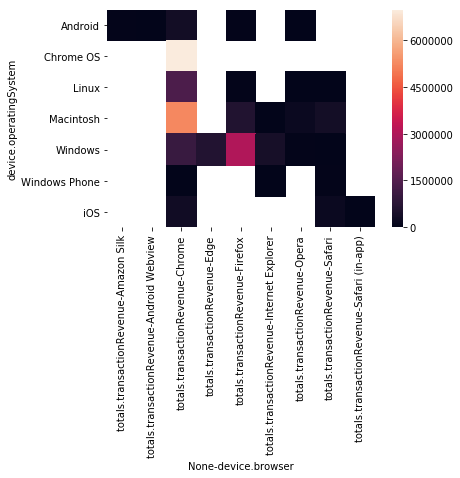

<Figure size 2880x2880 with 0 Axes>

In [22]:
piv = pd.pivot_table(df2, values=['totals.transactionRevenue'],index=["device.operatingSystem"], columns=["device.browser"])
ax = sns.heatmap(piv)
plt.figure(figsize=(40,40))
plt.show()

Text(0, 0.5, 'transaction revenue')

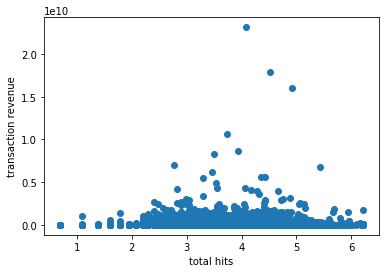

In [23]:
plt.scatter(df2['totals.hits'], df2['totals.transactionRevenue'])
plt.xlabel('total hits')
plt.ylabel('transaction revenue')

Text(0, 0.5, 'Total Transaction Revenue')

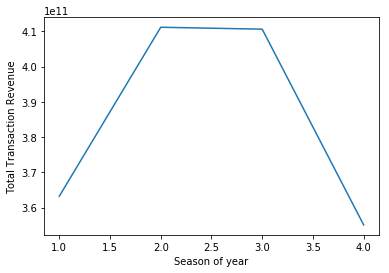

In [24]:
'''
  We will group the months into season such that:
  Winter -> January, February, December -> 1
  Spring -> March, April, May -> 2
  Summer -> June, July, August -> 3
  Fall -> September, October, November -> 4
  '''
seasons = []
rev_per_season = []

for i in range(1, 5, 1):
    seasons.append(i)
    rev_per_season.append(trainData.loc[(trainData['season'] == i ), 'totals.transactionRevenue'].sum())

plt.plot(seasons, rev_per_season)
plt.xlabel('Season of year')
plt.ylabel('Total Transaction Revenue')

Text(0, 0.5, 'Total Transaction Revenue')

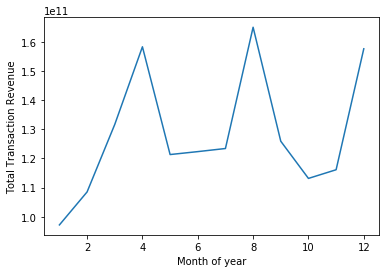

In [25]:
months = []
fare_per_month = []

for i in range(1, 13, 1):
    months.append(i)
    fare_per_month.append(trainData.loc[(trainData['month'] == i ), 'totals.transactionRevenue'].sum())


plt.plot(months, fare_per_month)
plt.xlabel('Month of year')
plt.ylabel('Total Transaction Revenue')

Text(0, 0.5, 'Total Transaction Revenue')

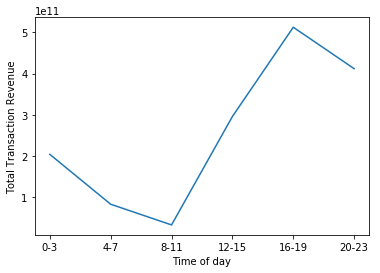

In [26]:
time = ['0-3','4-7','8-11','12-15','16-19','20-23']
rev_per_time = []

for i in range(1, 7, 1):
#     time.append(i)
    rev_per_time.append(trainData.loc[(trainData['time_of_day'] == i ), 'totals.transactionRevenue'].sum())


plt.plot(time, rev_per_time)
plt.xlabel('Time of day')
plt.ylabel('Total Transaction Revenue')

3. Cluster the data based on geographic information available with a subset of variables that you find relevant.  Include a visualization plot.  Describe your inferences from the clustering and discuss their significance.

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


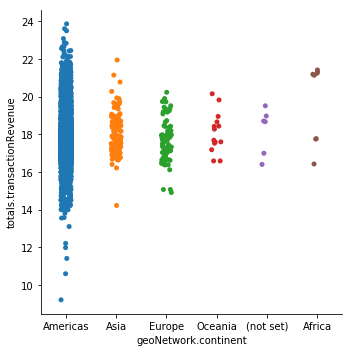

In [27]:
df1 = trainData[trainData['totals.transactionRevenue'] > 0.0]
df1['totals.transactionRevenue'] = np.log1p(trainData['totals.transactionRevenue'])
sns.catplot(x="geoNetwork.continent", y="totals.transactionRevenue", data=df1)

<BarContainer object of 6 artists>

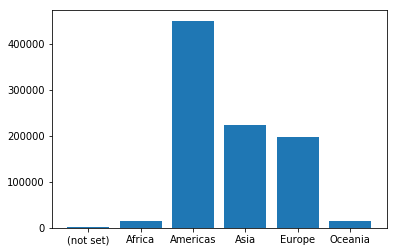

In [28]:
tdContinent = trainData.groupby('geoNetwork.continent')['totals.hits'].agg(['count', 'size'])
plt.bar(tdContinent.index, tdContinent['size'].values)

<BarContainer object of 6 artists>

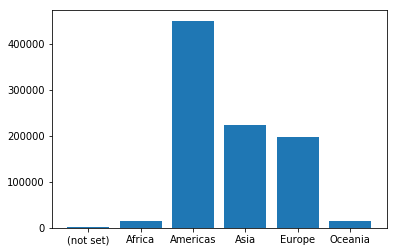

In [29]:
tdContinent = trainData.groupby('geoNetwork.continent')['totals.pageviews'].agg(['count', 'size'])
plt.bar(tdContinent.index, tdContinent['size'].values)

<BarContainer object of 4 artists>

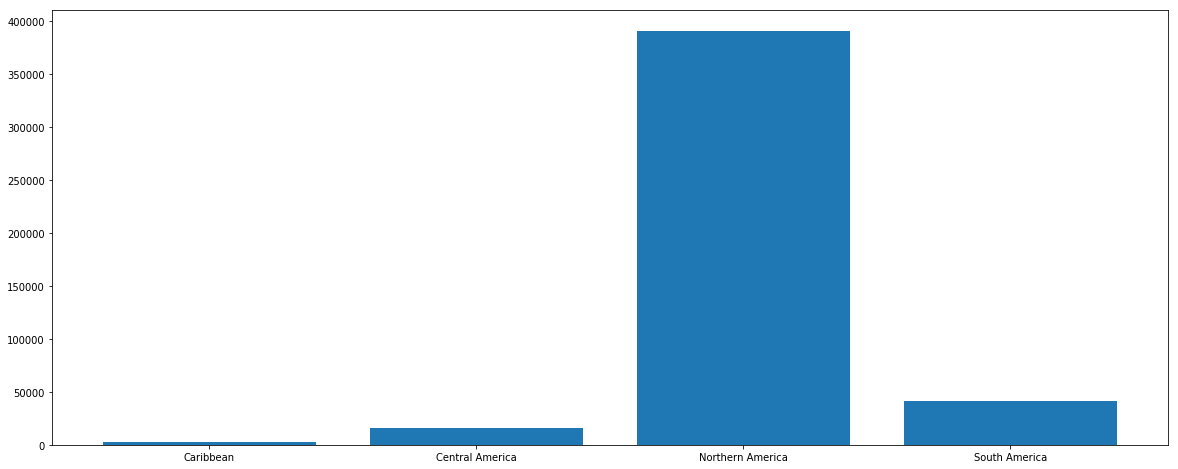

In [30]:
df1 = trainData[trainData['geoNetwork.continent'] == 'Americas']
tdContinent = df1.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['count', 'size'])
plt.figure(figsize=(20,8))
plt.bar(tdContinent.index, tdContinent['size'].values)

4. Define a buying score or probability function for each user, which predicts the likelihood of a user buying a product from the GStore. Rank the ten most likely users as who will buy a product from the store.  Does it seem that you that it produces good results?  Report why or why not.

In [31]:
td1 = trainData[trainData['totals.transactionRevenue'] > 0.0]
td1 = td1[td1['totals.hits'] > 0.0]
continentScore = {
    'Americas': 6,
    'Asia': 5,
    'Europe': 4,
    'Oceania': 3,
    'Africa': 2,
    '(not set)': 1
}
dateScore = {
    2016: 1,
    2017: 2
}
users = td1['fullVisitorId'].unique()
users
userScore = {}
for i in range(len(users)):
  contScore = sum(map(continentScore.get, td1.loc[td1['fullVisitorId'] == users[i], 'geoNetwork.continent'].tolist()))
  dScore = sum(map(dateScore.get, td1.loc[td1['fullVisitorId'] == users[i], 'year'].tolist()))
  userScore[users[i]] = 0.6 * ((td1.loc[td1['fullVisitorId'] == users[i], 'totals.transactionRevenue'].sum()) // (td1.loc[td1['fullVisitorId'] == users[i], 'totals.hits'].sum())) + 0.3 * (contScore) + 0.1 * (dScore)


In [32]:
topUsers = sorted(userScore, key = userScore.get, reverse = True)

In [33]:
topUsers[:10]

['5632276788326171571',
 '7496147812697146114',
 '7965265156545901045',
 '1957458976293878100',
 '5469079519715865124',
 '3769632740374536577',
 '79204932396995037',
 '4604965471651937146',
 '4067986469497332117',
 '9817395183603701442']

5. Identify at least one external data set which you can integrate into your transaction prediction analysis to make it better. Discuss/analyze the extent to which this data helps with the prediction task.

In [34]:
def add_gdp(df):
    gdpData = pd.read_csv('gdpNew.csv')
    df = pd.merge(df, gdpData,  how='left', left_on=['geoNetwork.country'], right_on = ['Country'])
    df.drop(['Country'],axis=1,inplace=True)
    return df

In [35]:
def add_internet(df):
    internetData = pd.read_csv('internet.csv')
    df = pd.merge(df, internetData,  how='left', left_on=['geoNetwork.country'], right_on = ['geoNetwork.country'])
    return df

In [36]:
def add_ext_data(df):
    df1 = add_gdp(df)
    df2 = add_internet(df1)
    return df2

In [37]:
trainData = add_ext_data(trainData)

6. Finally, build the best prediction model you can to solve the Kaggle task.  Use any data, ideas, and approach that you like. Submit the results of your best models on Kaggle.  Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. (20 points)

In [38]:
def delete_ids(df):
    cols = ['date', 'visitStartTime', 'fullVisitorId', 'sessionId', 'visitId', 'trafficSource.adwordsClickInfo.gclId']
    ids = df[cols]
    df.drop(cols, axis = 1, inplace=True)
    return df, ids

In [39]:
oldTrainData = trainData.copy()
trainData, trainIds = delete_ids(trainData)

GET TEST DATA

In [40]:
testData = pd.read_csv('test.csv', converters={column: json.loads for column in ["device", "geoNetwork", "totals", "trafficSource"]},dtype={'fullVisitorId': 'str', 'date': 'str', 'visitId': 'str'})

In [41]:
testData = clean_data(testData)

/usr/lib/python3.7/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [42]:
testData = add_features(testData)

In [43]:
testData = add_ext_data(testData)

In [44]:
oldTestData = testData.copy()
testData, testIds = delete_ids(testData)

Transform obj columns

In [45]:
def clearRare(columnname, limit = 1000):
    # you may search for rare categories in train, train&test, or just test
    #vc = pd.concat([train[columnname], test[columnname]], sort=False).value_counts()
    vc = testData[columnname].value_counts()
    
    common = vc > limit
    common = set(common.index[common].values)
    
    trainData.loc[trainData[columnname].map(lambda x: x not in common), columnname] = 'other'
    testData.loc[testData[columnname].map(lambda x: x not in common), columnname] = 'other'

In [46]:
clearRare("device.browser")
clearRare("device.operatingSystem")
clearRare("geoNetwork.country")
clearRare("geoNetwork.city")
clearRare("geoNetwork.networkDomain")
clearRare("geoNetwork.region")
clearRare("geoNetwork.subContinent")
clearRare("geoNetwork.continent")
# clearRare("browser_isMobile")
# clearRare("browser_deviceCat")
# clearRare("browser_os")
clearRare("trafficSource.medium")
clearRare("trafficSource.referralPath")
clearRare("trafficSource.source")

In [47]:
cols = ['geoNetwork.metro','geoNetwork.region', 'geoNetwork.subContinent', 'trafficSource.adwordsClickInfo.slot','trafficSource.adwordsClickInfo.page','trafficSource.adwordsClickInfo.adNetworkType','trafficSource.keyword','trafficSource.adContent','trafficSource.campaign','browser_isMobile', 'browser_deviceCat', 'browser_os']
# cols = ['browser_isMobile', 'browser_deviceCat', 'browser_os']
trainData.drop(cols,axis=1,inplace=True)
testData.drop(cols,axis=1,inplace=True)


In [48]:
def get_obj_col(df):
    obj_cols=[] 
    num_cols=[]
    for col in df.columns:
        if df[col].dtype == 'object':
            obj_cols.append(col)
        else:
            num_cols.append(col)
    return obj_cols, num_cols



In [49]:
obj_cols, num_cols = get_obj_col(trainData)
full_columns = obj_cols + num_cols

In [50]:
def labelEncode(dfTrainSeries, dfTestSeries):
    from sklearn import preprocessing
    encoder = preprocessing.LabelEncoder()
    encoder.fit(list(dfTrainSeries.values.astype('str'))+list(dfTestSeries.values.astype('str')))
    return encoder.transform(list(dfTrainSeries.values.astype('str'))), encoder.transform(list(dfTestSeries.values.astype('str')))

In [ ]:
for c in obj_cols:
    print("Starting Encode Process on ", c)
    trainData[c], testData[c] = labelEncode(trainData[c], testData[c])

Starting Encode Process on  channelGrouping
Starting Encode Process on  device.browser
Starting Encode Process on  device.deviceCategory
Starting Encode Process on  device.operatingSystem
Starting Encode Process on  geoNetwork.city
Starting Encode Process on  geoNetwork.continent
Starting Encode Process on  geoNetwork.country
Starting Encode Process on  geoNetwork.networkDomain
Starting Encode Process on  trafficSource.medium
Starting Encode Process on  trafficSource.referralPath


In [ ]:
Y_trainData = np.log1p(trainData['totals.transactionRevenue'])

In [ ]:
new_train = trainData.drop(['totals.transactionRevenue'],axis=1)

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_squared_error

In [ ]:
params = {'num_leaves': 300,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 1,
         "verbosity": 1}
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=False, random_state=42)
model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)

In [ ]:
def train_model(train_index, test_index):
    X_train, X_valid = new_train.iloc[train_index], new_train.iloc[test_index]
    y_train, y_valid = Y_trainData.iloc[train_index], Y_trainData.iloc[test_index]
    

    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',verbose=500, early_stopping_rounds=100)
    
    y_pred = model.predict(testData, num_iteration=model.best_iteration_)
    prediction += y_pred
    return prediction

In [ ]:
prediction = np.zeros(testData.shape[0])

for fold_n, (train_index, test_index) in enumerate(folds.split(new_train)):
    print('Fold:', fold_n)
    prediction = train_model(train_index, test_index, prediction)
    
prediction /= n_fold

In [ ]:
submission = oldTestData[['fullVisitorId']].copy()
submission.loc[:, 'PredictedLogRevenue'] = prediction
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].fillna(0.0)
grouped_test = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
grouped_test.to_csv('lgb2.csv',index=False)

7. Do a permutation test to determine whether your model really benefits from each input variable you use.   In particular, one at a time, for each relevant input variable, permute the value of this variable and see how they impact the accuracy of the results.  Run enough permutations per variable to establish a p-value of how good your predictions of log of sum of transactions per user are.  You can use whatever metric you wish to score your model (like mean absolute error).

In [ ]:
# df_train['pageviews'] = np.random.permutation(df_train['pageviews'])
different_rmse_ptest = []
# new_df['fullVisitorId'] = oldTrainData['fullVisitorId']
for colum in num_cols:
    print("For the variable " + str(colum) + ":")
    lst = []
    for i in range(1,4,1):
        new_train[colum] = np.random.permutation(new_train[colum])
        print("running",i)    
        fold_n = 1
        for fold_n, (train_index, test_index) in enumerate(folds.split(new_train)):
            X_train, X_valid = new_train.iloc[train_index], new_train.iloc[test_index]
            y_train, y_valid = Y_trainData.iloc[train_index], Y_trainData.iloc[test_index]

            
            model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',verbose=500, early_stopping_rounds=100)

            y_pred = model.predict(new_train, num_iteration=model.best_iteration_)
            p_val = model.predict(X_valid, num_iteration=model.best_iteration_)
            x_validation = X_valid.copy()

        p_val[p_val < 0] = 0
        
        
        df_prediction_final = pd.DataFrame({"fullVisitorId": X_valid["fullVisitorId"].values})
        df_prediction_final["transactionRevenue"] = y_valid.values
        df_prediction_final["PredictedRevenue"] = np.expm1(p_val)
        df_prediction_final = df_prediction_final.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
        
        lst.append(np.sqrt(metrics.mean_squared_error(np.log1p(df_prediction_final["transactionRevenue"].values), np.log1p(df_prediction_final["PredictedRevenue"].values))))
    lst = np.array(lst)
    print(lst.mean())
    different_rmse_ptest.append(lst.mean())


In [1]:
print(lst.mean())

2.3200876120078


TESTING OTHER MODELS

In [ ]:
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(new_train, Y_newTrain, test_size = 0.25)

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_valid)

In [ ]:
def evaluate(max_depth, gamma, colsample_bytree):
    params = {'eval_metric': 'rmse',
              'max_depth': int(max_depth),
              'subsample': 0.6,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree}
    result = xgb.cv(params, dtrain, num_boost_round=100, nfold=3)    
    
    return -1.0 * result['test-rmse-mean'].iloc[-1]

In [ ]:
xgb_with_bo = BayesianOptimization(evaluate, {'max_depth': (3, 6), 
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.3, 0.9)})

xgb_with_bo.maximize(init_points=3, n_iter=5, acq='ei')

In [ ]:
final_model_params = xgb_with_bo.res['max']['max_params']
final_model_params['max_depth'] = int(final_model_params['max_depth'])

In [ ]:
model_xgb = xgb.train(final_model_params, dtrain, num_boost_round=250)

In [ ]:
new_testdf_1 = xgb.DMatrix(new_testdf)

In [ ]:
y_pred = model_xgb.predict(new_testdf_1)

In [ ]:
sampleData = pd.read_csv('sample_submission.csv')
sampleData['fullVisitorId'] = y_pred
sampleData.to_csv('sample_new_result_xgb_bayesian_v2.csv', index=False)